In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pandas_profiling
import seaborn as sns
import datetime as dt

import xgboost as xgb# for XGBoost algorithm
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
# Set the default plot size
plt.rcParams['figure.figsize'] = [15, 8]
# set a grid for each plot too
sns.set_style("whitegrid")

In [3]:
df = pd.read_csv('solar_weather.csv', index_col='Time', parse_dates=True)

In [4]:
df.head()

,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
Time,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
2017-01-01 00:15:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
2017-01-01 00:30:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
2017-01-01 00:45:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
2017-01-01 01:00:00,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,0.0,4,1,1


## Prediction of Energy Delta using XGBoost 

In [5]:
df.index.min(),df.index.max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2022-08-31 17:45:00'))

#### Break up the data into training/testing dataset to analyze algorithm performance - using the whole dataset - strify based on month so that the same number of train samples come from each month.

In [6]:
# all columns except Energy Delta - the predictors
X = df.drop('Energy delta[Wh]', axis=1)
# Energy Delta - the target variable
y = df['Energy delta[Wh]']

# use stratify by montth to make sure we get the same number of days for each month - so the data doesn't get skewed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=X.index.month)
print('# train X:',len(X_train),'# test X:',len(X_test),'# train y:',len(y_train),'# test y:',len(y_test))

# train X: 137743 # test X: 59033 # train y: 137743 # test y: 59033


#### Since the target variable is continuous we need to use a regression style of model - and XGBoosts version is XGBRegressor

In [7]:
regr = XGBRegressor(objective ='reg:squarederror') # this is the defualt objective but i played with other - this gave the best result
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
# store the original and predicted value in a dataframe
df_final = pd.DataFrame(data={'Predictions':y_pred, 'Actuals':y_test })

In [8]:
# the model gives some negative predictions which doesn't make sense so set them to 0
print(df_final[df_final['Predictions']<0].head())

                     Predictions  Actuals
Time                                     
2022-02-01 00:00:00    -1.800409        0
2017-02-18 23:30:00    -1.204723        0
2022-01-06 05:45:00    -2.040714        0
2022-07-26 19:15:00    -1.929182        0
2017-10-29 00:45:00    -2.891612        0


In [9]:
# set these negative values to 0
df_final['Predictions'][df_final['Predictions']<0] = 0

C:\Users\Admin\AppData\Local\Temp\ipykernel_11920\2788824438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Predictions'][df_final['Predictions']<0] = 0


In [10]:
# print them again just to confirm
print(df_final[df_final['Predictions']==0].head())

                     Predictions  Actuals
Time                                     
2022-02-01 00:00:00          0.0        0
2017-02-18 23:30:00          0.0        0
2022-01-06 05:45:00          0.0        0
2022-07-26 19:15:00          0.0        0
2017-10-29 00:45:00          0.0        0



Accuragy for XGBRegressor = 0.93
The Coefficient of determination (R-squared) for XGBRegressor = 0.93
The mean absolute error (MAE) for XGBRegressor = 113.41
The RMSE error (RMSE) for XGBRegressor = 72424.56


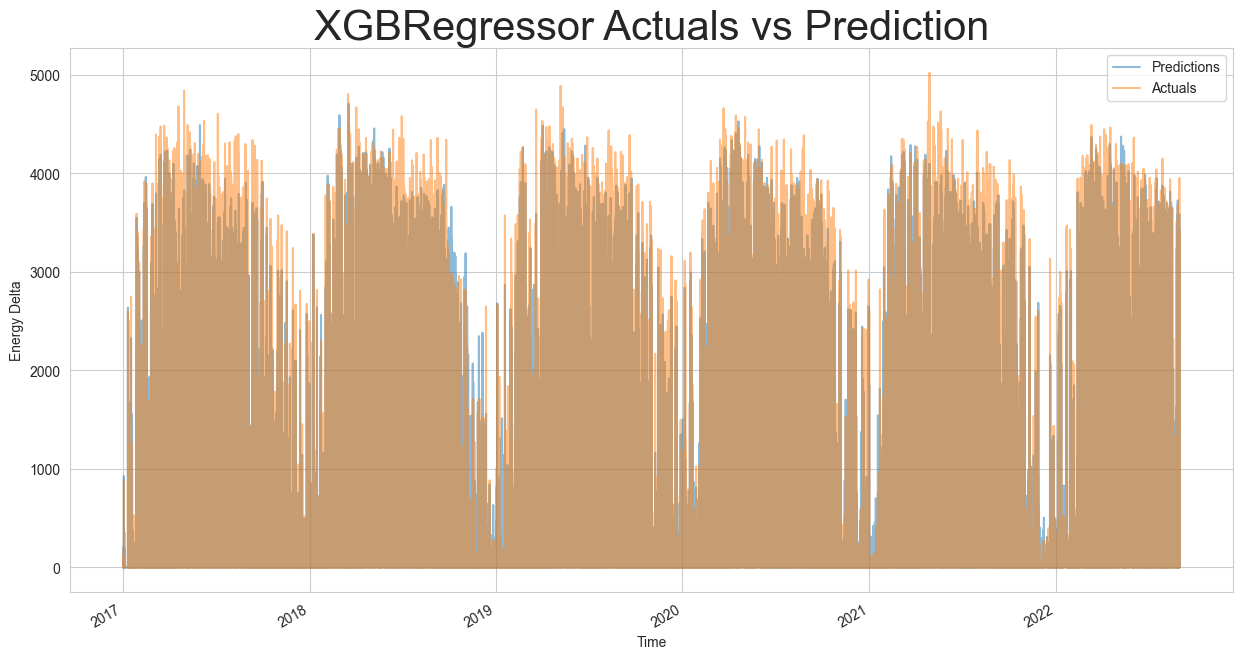

In [11]:
# zoom in to 300 values - note due to stratification the samples are random and the whole timeseries appears
df_final.plot(alpha=0.5) # reduce opacity to see both lines
plt.title('XGBRegressor Actuals vs Prediction', fontsize=30)
plt.ylabel('Energy Delta')
print('\nAccuragy for XGBRegressor = {:.2f}'.format(regr.score(X_test, y_test)))    
print('The Coefficient of determination (R-squared) for XGBRegressor = {:.2f}'.format(r2_score(df_final['Actuals'],df_final['Predictions'])))
print('The mean absolute error (MAE) for XGBRegressor = {:.2f}'.format(mean_absolute_error( df_final['Actuals'],df_final['Predictions'])))
print('The RMSE error (RMSE) for XGBRegressor = {:.2f}'.format(mean_squared_error( df_final['Actuals'],df_final['Predictions']), squared=True))

#### The R squared value of 0.94 means 94% of the variation in Energy delta is explained by the other parameters used as predictors

##### Let's look at some more algorithms to see if XGBoost is the best or can be improved upon

In [12]:
from sklearn import linear_model 
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [13]:
def regression_calculations(X_train, y_train, X_test, y_test, regressor):
    
    regr = regressor.fit(X_train,y_train)
    y_pred = regr.predict(X_test)
    # store the orignial and predicted value in a dataframe
    df_final = pd.DataFrame(data={'Predictions':y_pred, 'Actuals':y_test })      
    df_final.plot(alpha=0.5) # reduce opacity to see both lines
    plt.title(regressor, fontsize=30)
    plt.ylabel('Energy Delta')
    print('Accuragy for                                     ',regressor, ' = {:.4f}'.format(regr.score(X_test, y_test)))    
    print('The Coefficient of determination (R-squared) for ',regressor, ' = {:.2f}'.format(r2_score(df_final['Actuals'],df_final['Predictions'])))
    print('The mean absolute error (MAE) for                ',regressor, ' = {:.2f}'.format(mean_absolute_error( df_final['Actuals'],df_final['Predictions'])))
    print('The RMSE error (RMSE) for                        ',regressor, ' = {:.2f}'.format(mean_squared_error( df_final['Actuals'],df_final['Predictions']), squared=False))
    
    print('\n\n')

In [14]:
# define the different regressors
regressors = [LinearRegression(), DecisionTreeRegressor(), SVR(), linear_model.Lasso(), RandomForestRegressor(), GradientBoostingRegressor()] 

Accuragy for                                      LinearRegression()  = 0.8550
The Coefficient of determination (R-squared) for  LinearRegression()  = 0.85
The mean absolute error (MAE) for                 LinearRegression()  = 222.99
The RMSE error (RMSE) for                         LinearRegression()  = 157148.64



Accuragy for                                      DecisionTreeRegressor()  = 0.8696
The Coefficient of determination (R-squared) for  DecisionTreeRegressor()  = 0.87
The mean absolute error (MAE) for                 DecisionTreeRegressor()  = 147.45
The RMSE error (RMSE) for                         DecisionTreeRegressor()  = 141309.28



Accuragy for                                      SVR()  = 0.4329
The Coefficient of determination (R-squared) for  SVR()  = 0.43
The mean absolute error (MAE) for                 SVR()  = 358.74
The RMSE error (RMSE) for                         SVR()  = 614393.29



Accuragy for                                      Lasso()  = 0.8546
The 

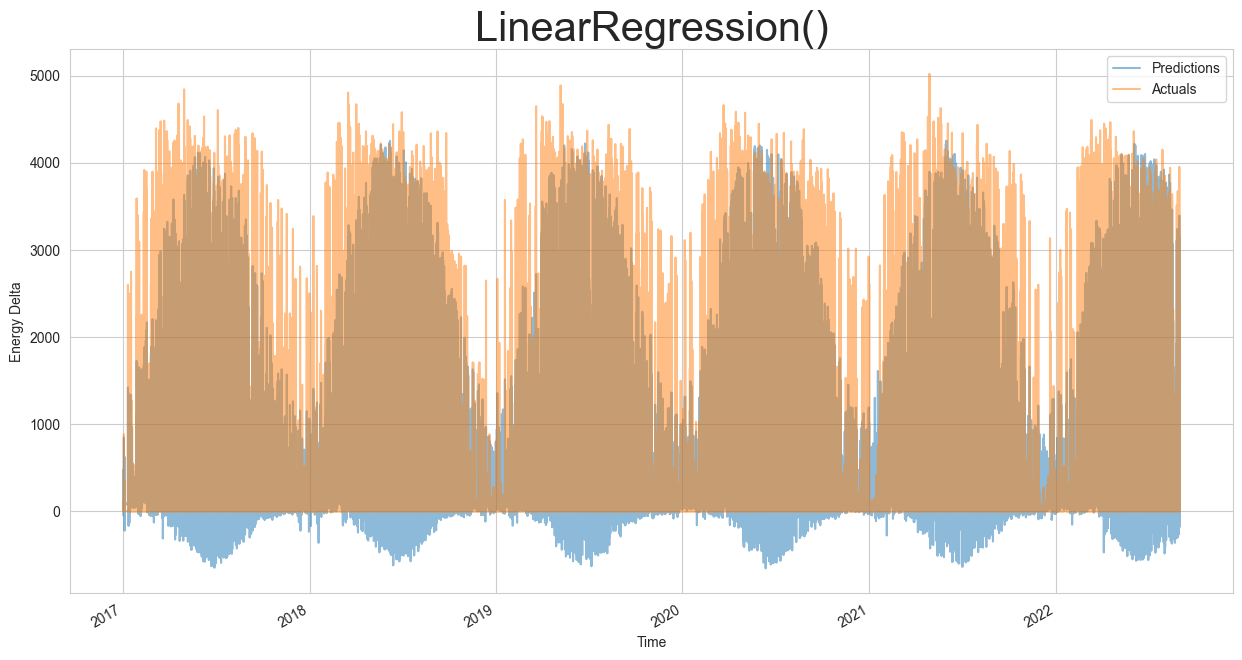

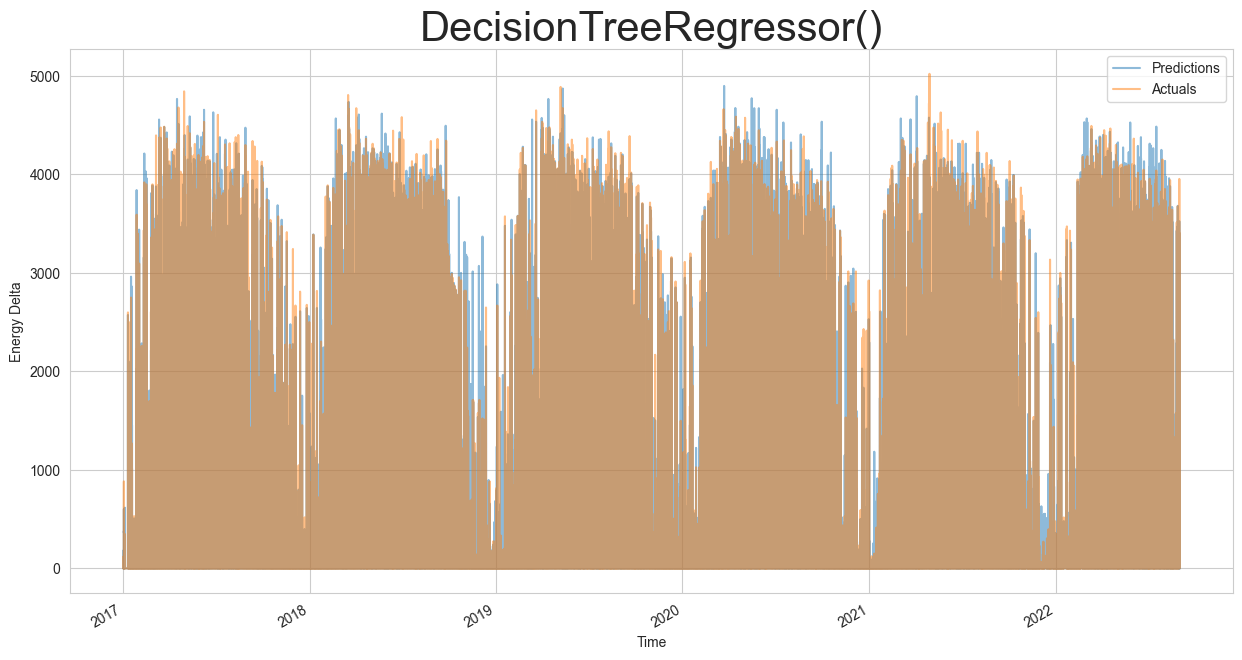

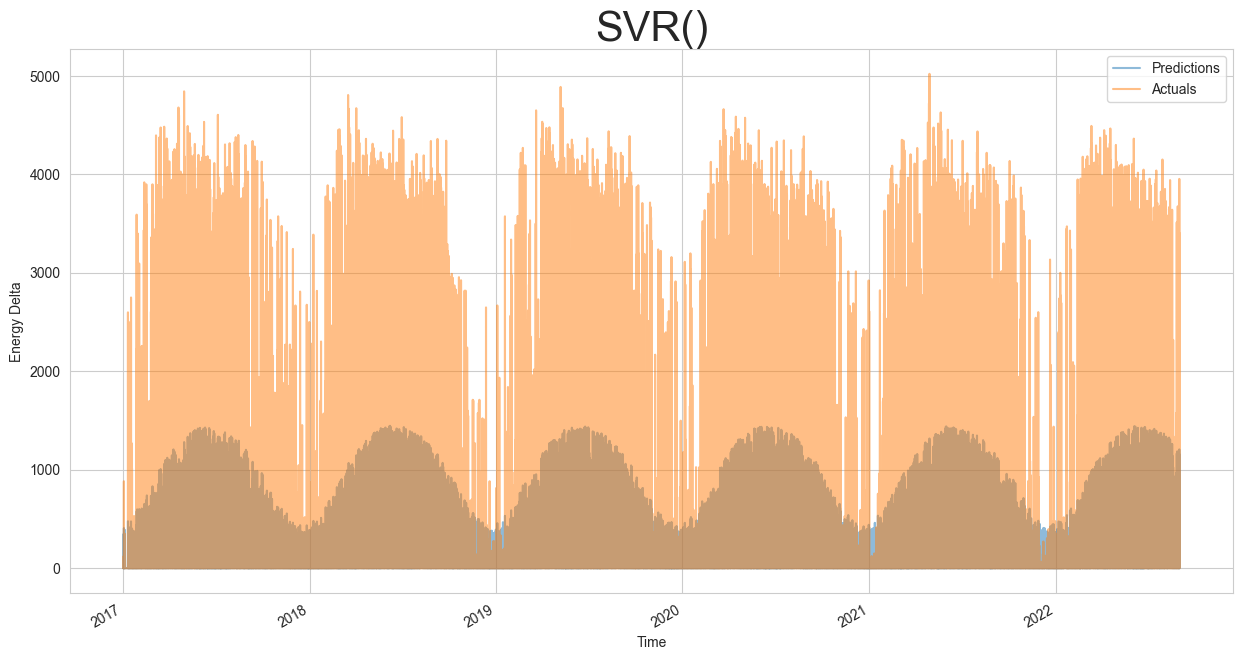

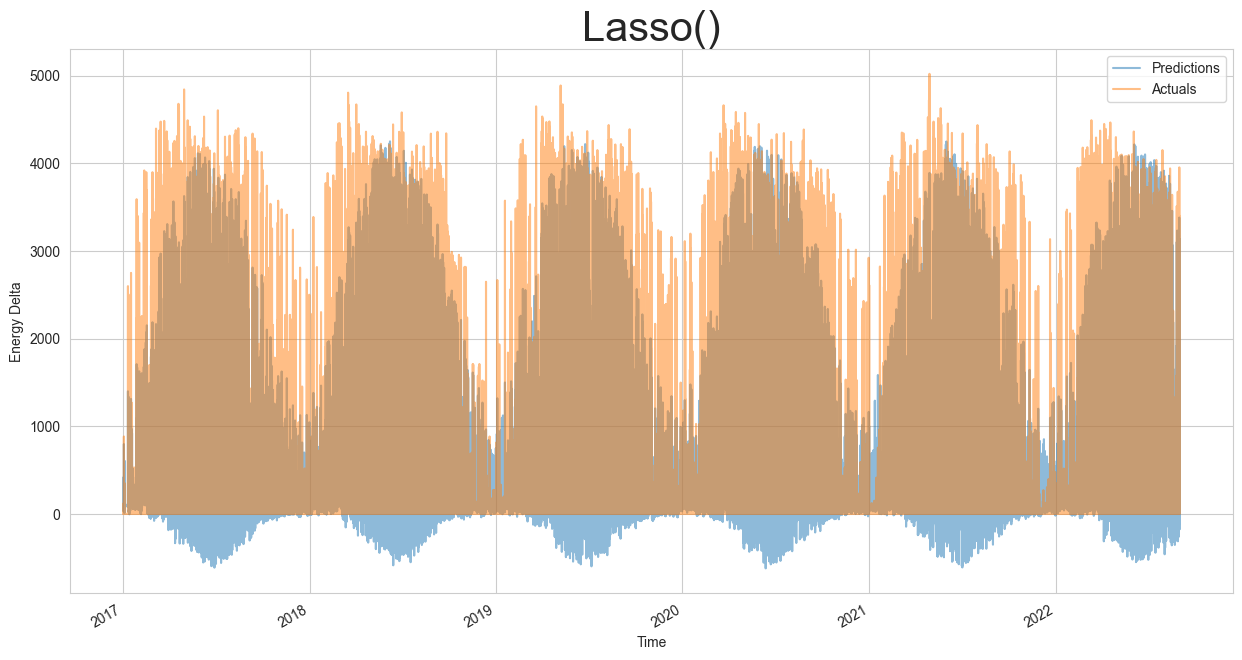

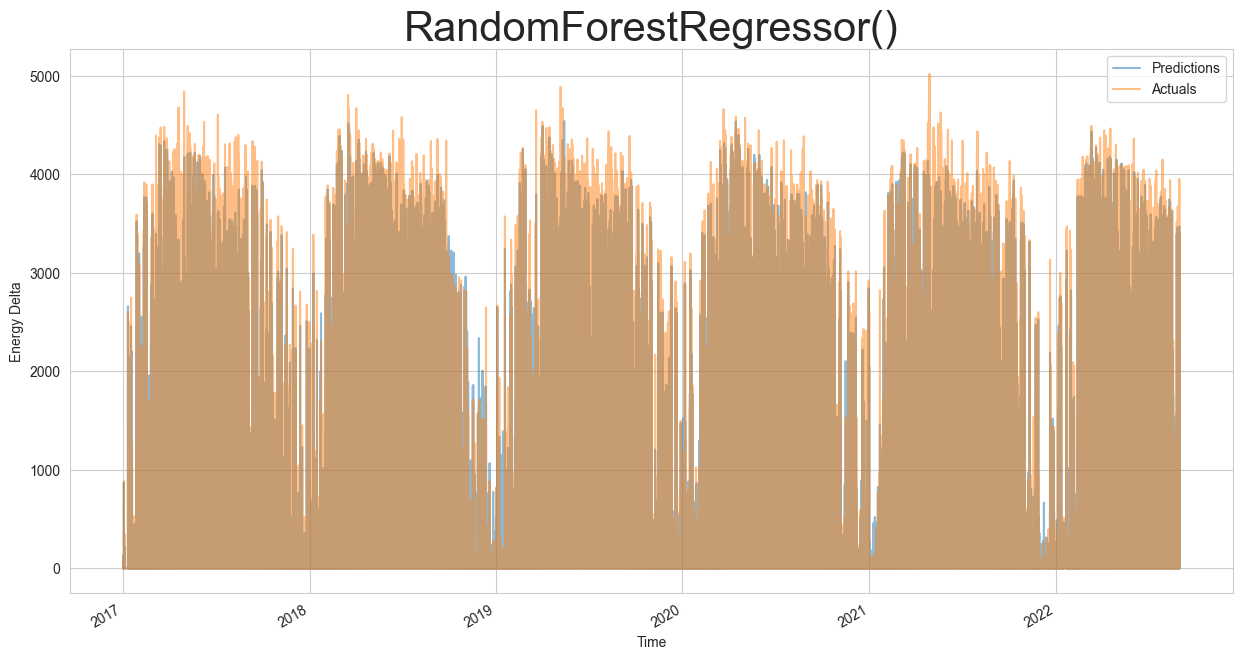

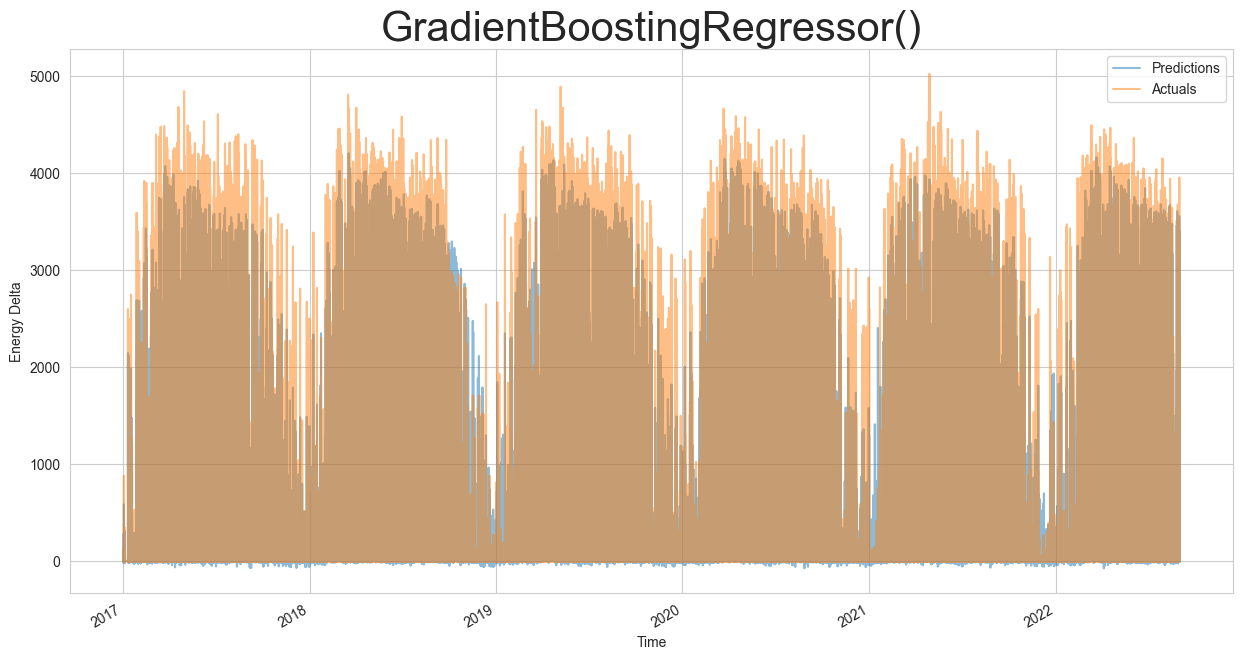

In [15]:
#loop through the different regressors
for regressor in regressors:
    pred = regression_calculations(X_train, y_train, X_test, y_test, regressor)